In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
plt.style.use('ggplot')
%matplotlib inline

#### 1. Read production data from CSV file

In [2]:
#Extract api#, monthly_oil and date from Drillinginfo File
df = pandas.read_csv('Monthly_Production.CSV')
oil = np.array(df['Monthly Oil'].values)
api_well = np.array(df['API/UWI'].values)
pro_month = np.array(df['Monthly Production Date'].values)
unique_ids=len(np.unique(api_well))
print('Total number of wells are: {}'.format (unique_ids)) # Confirming all 153 wells are read into memory

Total number of wells are: 153


#### 2. Data Preparation
* Split each individual well's production data into an array
* Pick a well, and plot the original production data
* Take first 12 month of log(oil rate) as training data

In [3]:
ID_0 = api_well[0]
i=0
j=0
k=0
oil_array=np.zeros((unique_ids,36),dtype=int)
for ID in api_well:
    if ID==ID_0:
        oil_array[i,j]=oil[k]
        j=j+1
    else:
        ID_0=ID
        i=i+1
        j=0
    k=k+1 

**Selecting well number 3 production data for fitting**

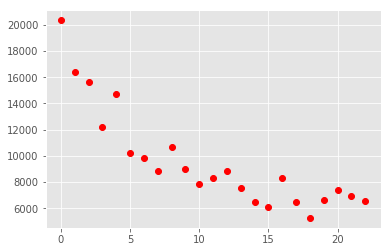

In [33]:
cur = oil_array[3]
rec_month = np.count_nonzero(cur)
plt.plot(cur[:rec_month],'ro');

#### Selecting log transformed first twelve months of data for fitting

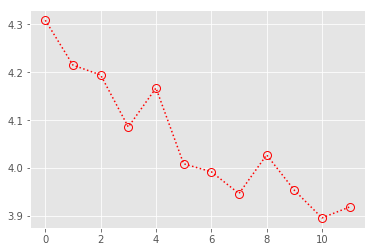

In [5]:
data = np.log10(cur[0:12])
marker_style = dict(color='r', linestyle=':', marker='o',
                    markersize=8, markerfacecoloralt='gray')
plt.plot(data,fillstyle='none',**marker_style);

#### 3. Define Arps equation and get best estimate using least square residual. Plot data, initial guess and best estimate
Arps correlation is provided as below:
$$Q_t=Q_i(1+bD_it)^{-\frac{1}{b}}$$
Where $Q_i$, $b$, $D_i$ are the parameters to be fitted. Which represent initial production from the well, Arps decline exponent and Arps's initial decline rate respectively.  

In [6]:
def Arps(t,Di,logQi,b):
    Qt = logQi - 1/b*np.log10(1+b*Di*t)
    return Qt

In [7]:
Di = 0.5
logQi = 4
b = 0.5
t = np.linspace(0,11,12)
y_init =  Arps(t,Di,logQi,b)
params, params_covariance = optimize.curve_fit(Arps, t, data,
                                               p0=[0.22,4.3,2])
y_hat = Arps(t,params[0],params[1],params[2])
sigma = np.sqrt(np.sum(np.power(data-y_hat,2))/(len(data)-3))
#sigma=0.5
print('The best estimate are: \n D = {}\n log(Qi) = {}\n b = {}'.format(params[0],params[1],params[2]))
print('Variance is {}'.format(sigma))

The best estimate are: 
 D = 0.20729147509120985
 log(Qi) = 4.30665046383042
 b = 1.7332769791197018
Variance is 0.044973262802623794


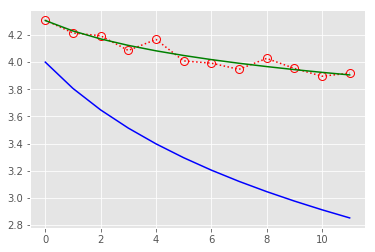

In [8]:
plt.plot(y_init,'b-') # initial guess
plt.plot(data,fillstyle='none',**marker_style)
plt.plot(y_hat,'g-');

#### 4. MCMC for parameter estimation
  * Define posterior function
  * Initialize the chain
  * Sampling from posterior distribution

In [9]:
def post(Di,logQi,b,sigma,t,data):
    like = np.prod(np.exp(-np.power(Arps(t,Di,logQi,b)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [10]:
logQi = data[0]
Niter = 100000
chain = np.zeros((Niter,3))
chain[0,0] = Di # Initialize the chain with first guess
chain[0,1] = logQi
chain[0,2] = b

In [35]:
for ii in np.arange(Niter-1):
        if ii%10000 ==0:
            print('iteration {}'.format(ii))
        Di    = chain[ii,0] 
        logQi = chain[ii,1] 
        b     = chain[ii,2] 
        #sigma = chain[ii,3]
        Di_p    = Di + np.random.normal(loc=0.0,scale=0.1,size=1)
        logQi_p = logQi + np.random.normal(loc=0.0,scale=0.1,size=1)
        b_p     = b + np.random.normal(loc=0.0,scale=0.1,size=1)
        
        if Di_p < 0.1 or Di_p>50 or b_p<0 or b_p>=2 or logQi > 1000000 or logQi<0.01:
            chain[ii+1,:] = chain[ii,:]
        elif (post(Di_p,logQi_p,b_p,sigma,t,data) / post(Di,logQi,b,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = Di_p 
            chain[ii+1,1] = logQi_p 
            chain[ii+1,2] = b_p 
        else:
            chain[ii+1,:] = chain[ii,:]
print('Sampling finished at iteration {}'.format(Niter))

iteration 0


C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\peace\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


iteration 10000
iteration 20000
iteration 30000
iteration 40000
iteration 50000
iteration 60000
iteration 70000
iteration 80000
iteration 90000
Sampling finished at iteration 100000


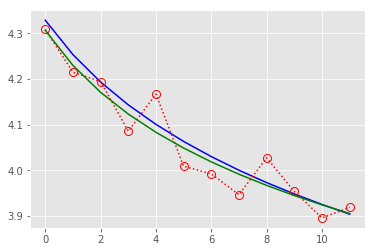

In [12]:
y_theta =  Arps(t,Di,logQi,b)
plt.plot(y_theta,'b-')
plt.plot(data,'ro',fillstyle='none',**marker_style)
plt.plot(y_hat,'g-');

### Plot of 1000 draws from the posterios

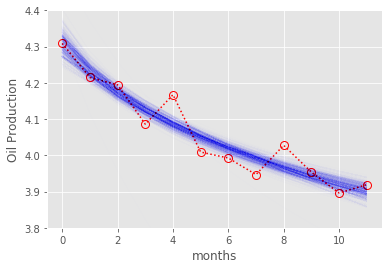

In [13]:
chains_to_plot=np.arange(1000)*9

fig = plt.figure()
aa = plt.axes()
aa.plot(data,'ro',fillstyle='none',**marker_style)
#aa.plot(y_hat,'g-')
kk=0
qq=np.zeros([len(chains_to_plot),len(t)])
for ii in chains_to_plot:
    qq[kk,:]=Arps(t,chain[ii,0],chain[ii,1],chain[ii,2])
    aa.plot(qq[kk,:],color='blue',alpha=0.002)
    kk+=1
    aa.set(ylim=(3.8, 4.4),xlabel='months', ylabel='Oil Production')

### Posterior Summary

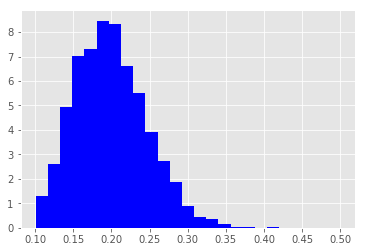

In [14]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,0],25,density=True,color='blue')

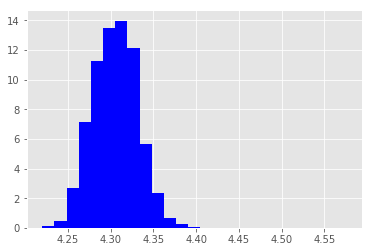

In [15]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,1],25,density=True,color='blue')

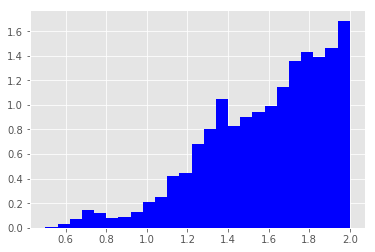

In [16]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,2],25,density=True,color='blue')

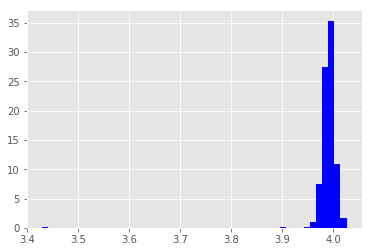

In [17]:
#Histogram of prediction for a given month for all the different MCMCs
month=7
fig = plt.figure()
ax = plt.axes()
rectangles= ax.hist(qq[:,month],50,density=True,color='blue')

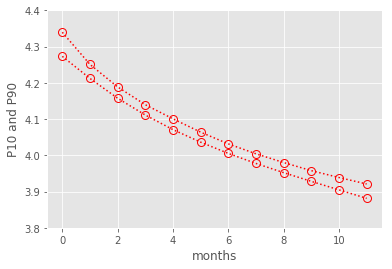

In [18]:
qq_p10=np.zeros(len(t))
qq_p90=np.zeros(len(t))
for tt in np.arange(0,12):
    sorted_qq=np.sort(qq[:,tt])
    ixL = np.floor(np.size(sorted_qq)*.1).astype(int) ## lower index
    ixU = np.floor(np.size(sorted_qq)*.9).astype(int) ## upper index
    qq_p10[tt]=sorted_qq[ixL]
    qq_p90[tt]=sorted_qq[ixU]

fig = plt.figure()
aa = plt.axes()
aa.plot(qq_p10,'ro',fillstyle='none',**marker_style)
aa.plot(qq_p90,'ro',fillstyle='none',**marker_style)
aa.set(ylim=(3.8, 4.4),xlabel='months', ylabel='P10 and P90');

In [19]:
print(chain[99999,0],chain[99999,1],chain[99999,2])

0.19729653868343372 4.3287275149000655 1.4616491228749855


In [20]:
print(Di,logQi,b,sigma)

0.19729653868343372 4.3287275149000655 1.4616491228749855 0.044973262802623794


In [21]:
print(chain[99998,0],chain[99998,1],chain[99998,2])

0.19729653868343372 4.3287275149000655 1.4616491228749855


In [22]:
print(chain[-3,0],chain[-3,1],chain[-3,2])

0.19729653868343372 4.3287275149000655 1.4616491228749855


(100000, 3)

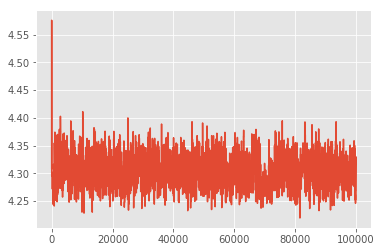

In [23]:
plt.plot(chain[:,1])
chain.shape

In [24]:
chain[-100:,:]

array([[0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.16592996, 4.31660418, 1.26031809],
       [0.